# Customer Churn EDA & Prediction

1. Questions asked
2. Datasets used
3. ETL process
4. Technologies used
5. Data Preprocessing
6. Logistic Regression (ML)
7. Conclusions

## 0.5 Importing Libraries & Dependencies

In [2]:
import json
import pandas as pd
import numpy as np
import joblib
import os
import pymysql
import seaborn as sns
from datetime import datetime
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## 1. The Dataset

## 2. Questions Asked & Technologies Used

## 3. ETL Process

## 4. EDA & Power BI

## 5. Data Preprocessing

In [3]:
## Get credentials from environment variables
host = os.environ['DB_HOST']
port = os.environ['DB_PORT']
user = os.environ['DB_USER']
password = os.environ['DB_PASSWORD']
database = os.environ['DB_NAME']

In [17]:
# Extract data from mysql db

## Create sqlalchemy engine for db connection
try:
    connection_string = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(connection_string)
    print('Successfully connected to MySQL database')
    
except Exception as e:
    print(f"Error connecting to database: {e}")
    

Successfully connected to MySQL database


In [18]:
## Read in sql query (it's kind of a monster, so I exciled it to its own file)
with open('aggregation_query.sql', 'r') as f:
    query = f.read()
    

In [19]:
## Extract data
try:
    df = pd.read_sql(query, engine)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns")
    print(df.describe())
    
except Exception as e:
    print(f"Error loading data: {e}")
    

Loaded 7043 rows and 32 columns
       tenure_months          age  is_under_30  is_senior_citizen  \
count    7043.000000  6832.000000  6832.000000         6832.00000   
mean       32.371149    46.527664     0.198917            0.16291   
std        24.559481    16.763525     0.399215            0.36931   
min         0.000000    19.000000     0.000000            0.00000   
25%         9.000000    32.000000     0.000000            0.00000   
50%        29.000000    46.000000     0.000000            0.00000   
75%        55.000000    60.000000     0.000000            0.00000   
max        72.000000    80.000000     1.000000            1.00000   

       has_partner  has_dependents  number_of_dependents  \
count  6832.000000     6832.000000           6832.000000   
mean      0.481265        0.228923              0.464286   
std       0.499685        0.420170              0.958767   
min       0.000000        0.000000              0.000000   
25%       0.000000        0.000000            

There appear to be quite a few missing values post-ETL, so we'll need to handle that in our preprocessing (via Imputing) along with the categorical values, numerical standardization, and splitting the data into training and test sets.

In [20]:
## Given that missingness is random, we'll drop rows with missing values
df = df.dropna()
df.info()
## 
plt.figure(figsize=(14,7))
df.corr(numeric_only=True)['churn_label'].sort_values(ascending = False)

<class 'pandas.core.frame.DataFrame'>
Index: 6043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tenure_months                      6043 non-null   int64  
 1   age                                6043 non-null   float64
 2   is_under_30                        6043 non-null   float64
 3   is_senior_citizen                  6043 non-null   float64
 4   has_partner                        6043 non-null   float64
 5   has_dependents                     6043 non-null   float64
 6   number_of_dependents               6043 non-null   float64
 7   contract_type                      6043 non-null   object 
 8   has_paperless_billing              6043 non-null   float64
 9   payment_method                     6043 non-null   object 
 10  monthly_charges                    6043 non-null   float64
 11  total_refunds                      6043 non-null   float64
 1

churn_label                          1.000000
churn_score                          0.661853
has_internet_service                 0.226659
monthly_charges                      0.193941
has_paperless_billing                0.191296
has_unlimited_data                   0.162486
is_senior_citizen                    0.147389
age                                  0.109902
has_movies                           0.063752
has_tv                               0.061664
avg_monthly_gb_download              0.049645
has_music                            0.047914
has_phone_service                    0.013764
total_extra_data_charges             0.008300
avg_monthly_long_distance_charges    0.007685
total_refunds                       -0.029324
is_under_30                         -0.053676
has_device_protection               -0.067045
has_online_backup                   -0.083639
has_partner                         -0.146707
has_referred_a_friend               -0.147706
has_tech_support                  

<Figure size 1400x700 with 0 Axes>

In [27]:
## Remove churn column
X = df.drop(columns = ['churn_label'])
y = df['churn_label'].values

## Splitting up data into training & testing (done first to prevent leakage from standardization)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
## Define columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = ['tenure_months', 'age', 'number_of_dependents', 'monthly_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'number_of_referrals', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'satisfaction_score', 'churn_score']

## Define preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

## Chaining together preprocessing step and training into one obj with Pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])


## 6. Logistic Regression Model

In [23]:
## Fit the model
clf.fit(X_train, y_train)

## Compute model accuracy
accuracy = clf.score(X_test, y_test)
print("Logistic Regression accuracy is :", accuracy)


Logistic Regression accuracy is : 0.9669148056244831


In [24]:
##
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]   # probability of churn
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       886
           1       0.95      0.92      0.94       323

    accuracy                           0.97      1209
   macro avg       0.96      0.95      0.96      1209
weighted avg       0.97      0.97      0.97      1209



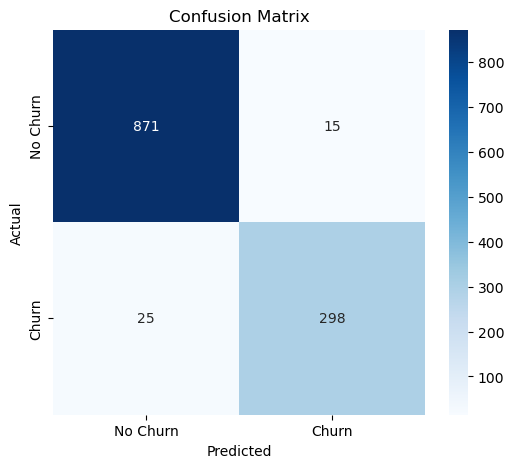

In [25]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

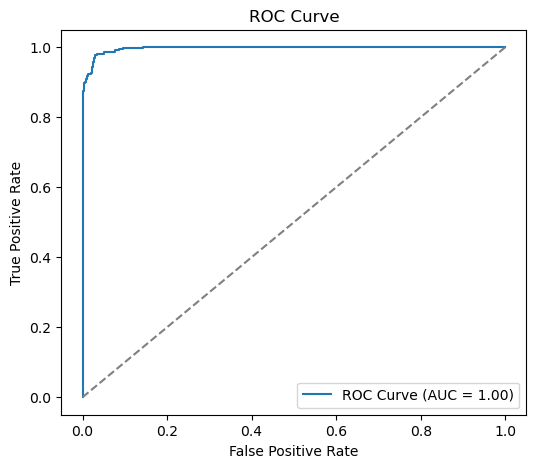

In [26]:
## ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

After looking at the correlation between different fields and churn, there are a few extremely strong indicators: churn_score and satisfaction_score. The churn score was calculated by the datasets' creator IBM and is defined as the liklihood of a customer churning from 0-100. Similarly, the satisfaction score is a fictional metric that measure the customer's satisfaction with the company's services from 1-5. It makes sense that both strongly correlate with churn and are likely responsible for this model's uncanny accuracy. It feels unlikely real world data would include such powerful fields, so let's explore further by retraining the model without those two fields. Instead of including redundant code I just added screenshots of the results.


### Retrained model minus churn_score and satisfaction_score
![Confusion Matrix](conf_matrix.png)
![ROC Curve](roc.png)
![Metrics](metrics.png)


Looking at each of these visualizations it's immediately noticable that there is quite a drop in performance. In particular, the F1 score for Positive Churn took quite a hit, which makes intuitive sense given satisfaction ratings and churn risk score would correlate quite linearly with churn.